In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas Celseq", "Pancreas CelSeq2"]

# Loading 5 Pancreas datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 12196 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 3725 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Normalization

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [11]:
train_adata.shape, valid_adata.shape

((9756, 2000), (2440, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             scale_factor=1.0,
                             clip_value=3.0,
                             use_batchnorm=True,
                             loss_fn='nb',
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:154: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256384      concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [14]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=32, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 9756 samples, validate on 2440 samples
Epoch 1/10000
 - 2s - loss: 48210.0586 - nb: 48210.0586 - val_loss: 45246.9195 - val_nb: 45246.9195
Epoch 2/10000
 - 1s - loss: 42053.9821 - nb: 42053.9820 - val_loss: 44006.4512 - val_nb: 44006.4512
Epoch 3/10000
 - 1s - loss: 41641.8764 - nb: 41641.8763 - val_loss: 43437.4830 - val_nb: 43437.4830
Epoch 4/10000
 - 1s - loss: 41453.6199 - nb: 41453.6199 - val_loss: 43475.6432 - val_nb: 43475.6432
Epoch 5/10000
 - 1s - loss: 41355.8719 - nb: 41355.8719 - val_loss: 43288.0905 - val_nb: 43288.0905
Epoch 6/10000
 - 1s - loss: 41296.7619 - nb: 41296.7618 - val_loss: 43268.5456 - val_nb: 43268.5456
Epoch 7/10000
 - 1s - loss: 41268.2560 - nb: 41268.2559 - val_loss: 43166.5554 - val_nb: 43166.5554
Epoch 8/10000
 - 1s - loss: 41212.2607 - nb: 41212.2605 - val_loss: 43146.0548 - val_nb: 43146.0548
Epoch 9/10000
 - 1s - loss: 41190.9217 - nb: 41190.9216 - val_loss: 43107.0672 - val_nb: 43107.0672
Epoc

In [16]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9756 × 10 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

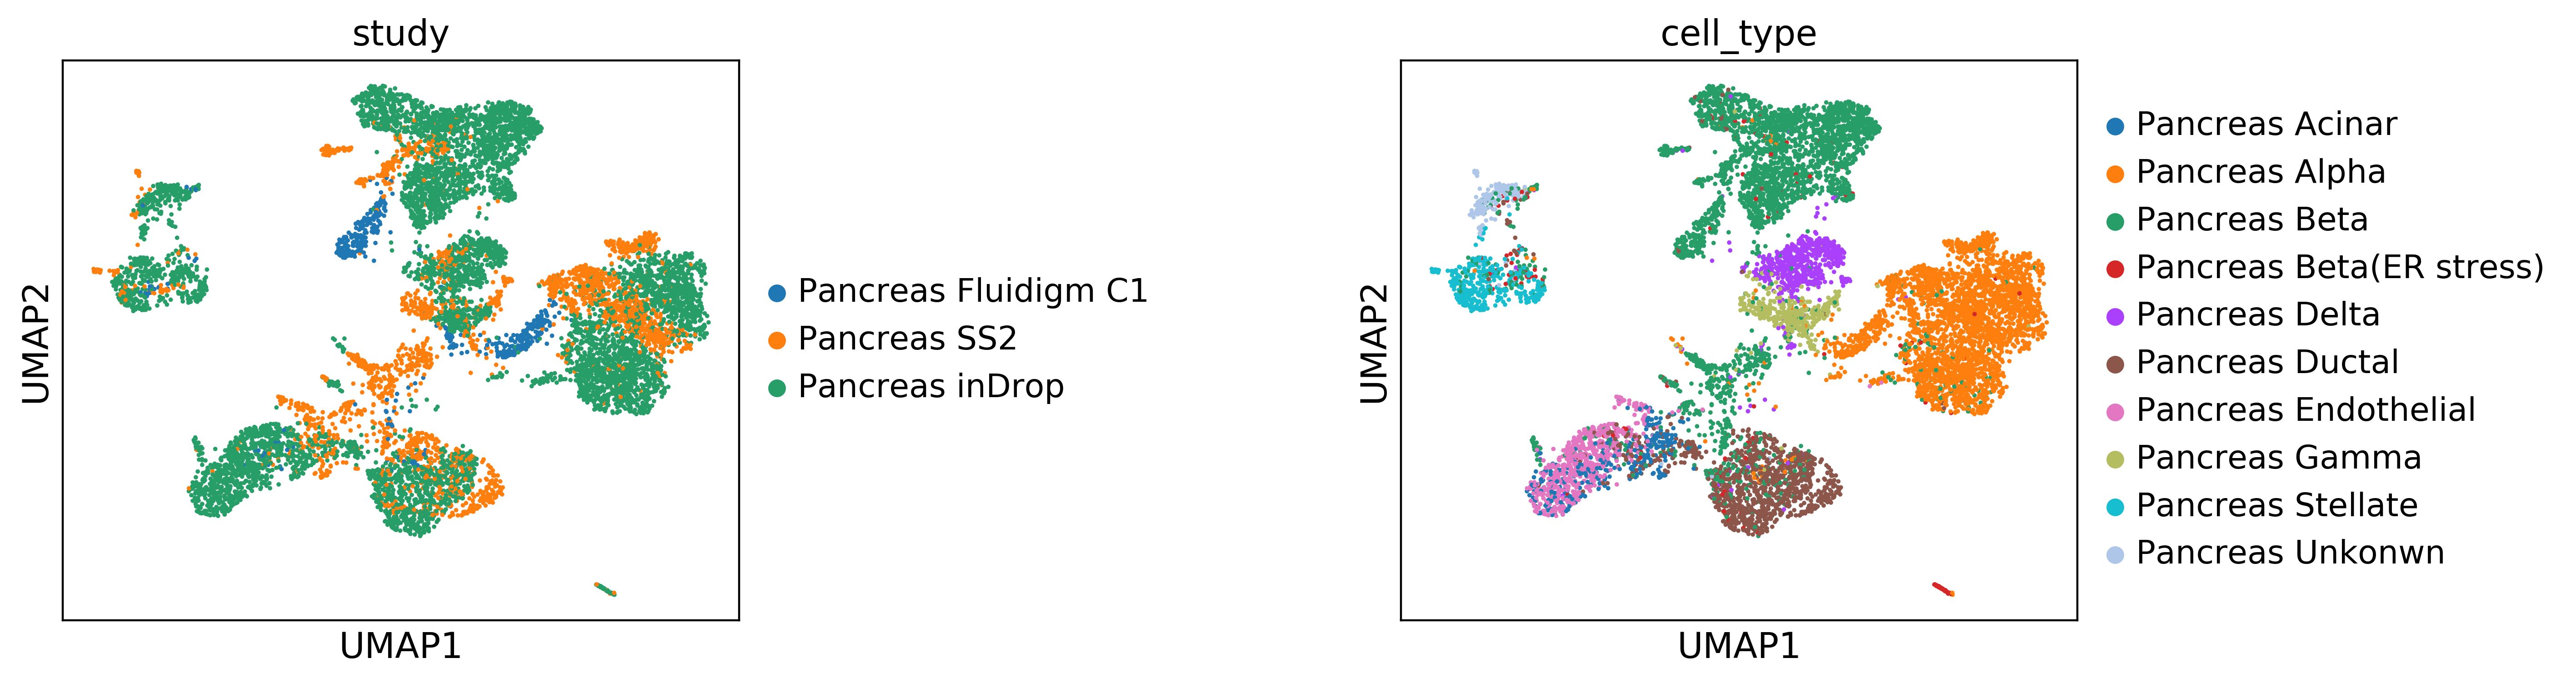

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.8)

# Perfroming architecture Surgery

In [21]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:154: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256640      concatenate_3[0][0]              
__________

## Train with small new dataset containing out-of-sample condition

In [22]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [23]:
train_adata.shape, valid_adata.shape

((3166, 2000), (559, 2000))

In [24]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=500,
                  batch_size=64, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True, 
                  verbose=2)

Train on 3166 samples, validate on 559 samples
Epoch 1/500
 - 1s - loss: 177916.1169 - nb: 177916.1169 - val_loss: 155806.8755 - val_nb: 155806.8755
Epoch 2/500
 - 0s - loss: 156136.3403 - nb: 156136.3397 - val_loss: 143275.0654 - val_nb: 143275.0654
Epoch 3/500
 - 0s - loss: 147772.6696 - nb: 147772.6696 - val_loss: 141511.4016 - val_nb: 141511.4016
Epoch 4/500
 - 0s - loss: 143852.2599 - nb: 143852.2602 - val_loss: 137893.7444 - val_nb: 137893.7444
Epoch 5/500
 - 0s - loss: 140794.1079 - nb: 140794.1079 - val_loss: 141494.5885 - val_nb: 141494.5885
Epoch 6/500
 - 0s - loss: 139136.5124 - nb: 139136.5124 - val_loss: 138471.5379 - val_nb: 138471.5379
Epoch 7/500
 - 0s - loss: 137465.6786 - nb: 137465.6786 - val_loss: 137887.3800 - val_nb: 137887.3800
Epoch 8/500
 - 0s - loss: 136292.9861 - nb: 136292.9855 - val_loss: 137245.8199 - val_nb: 137245.8199
Epoch 9/500
 - 0s - loss: 135102.9048 - nb: 135102.9045 - val_loss: 136670.2772 - val_nb: 136670.2772
Epoch 10/500
 - 0s - loss: 134488.9

In [25]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(3725, 1)

In [26]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 3725 × 10 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [27]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

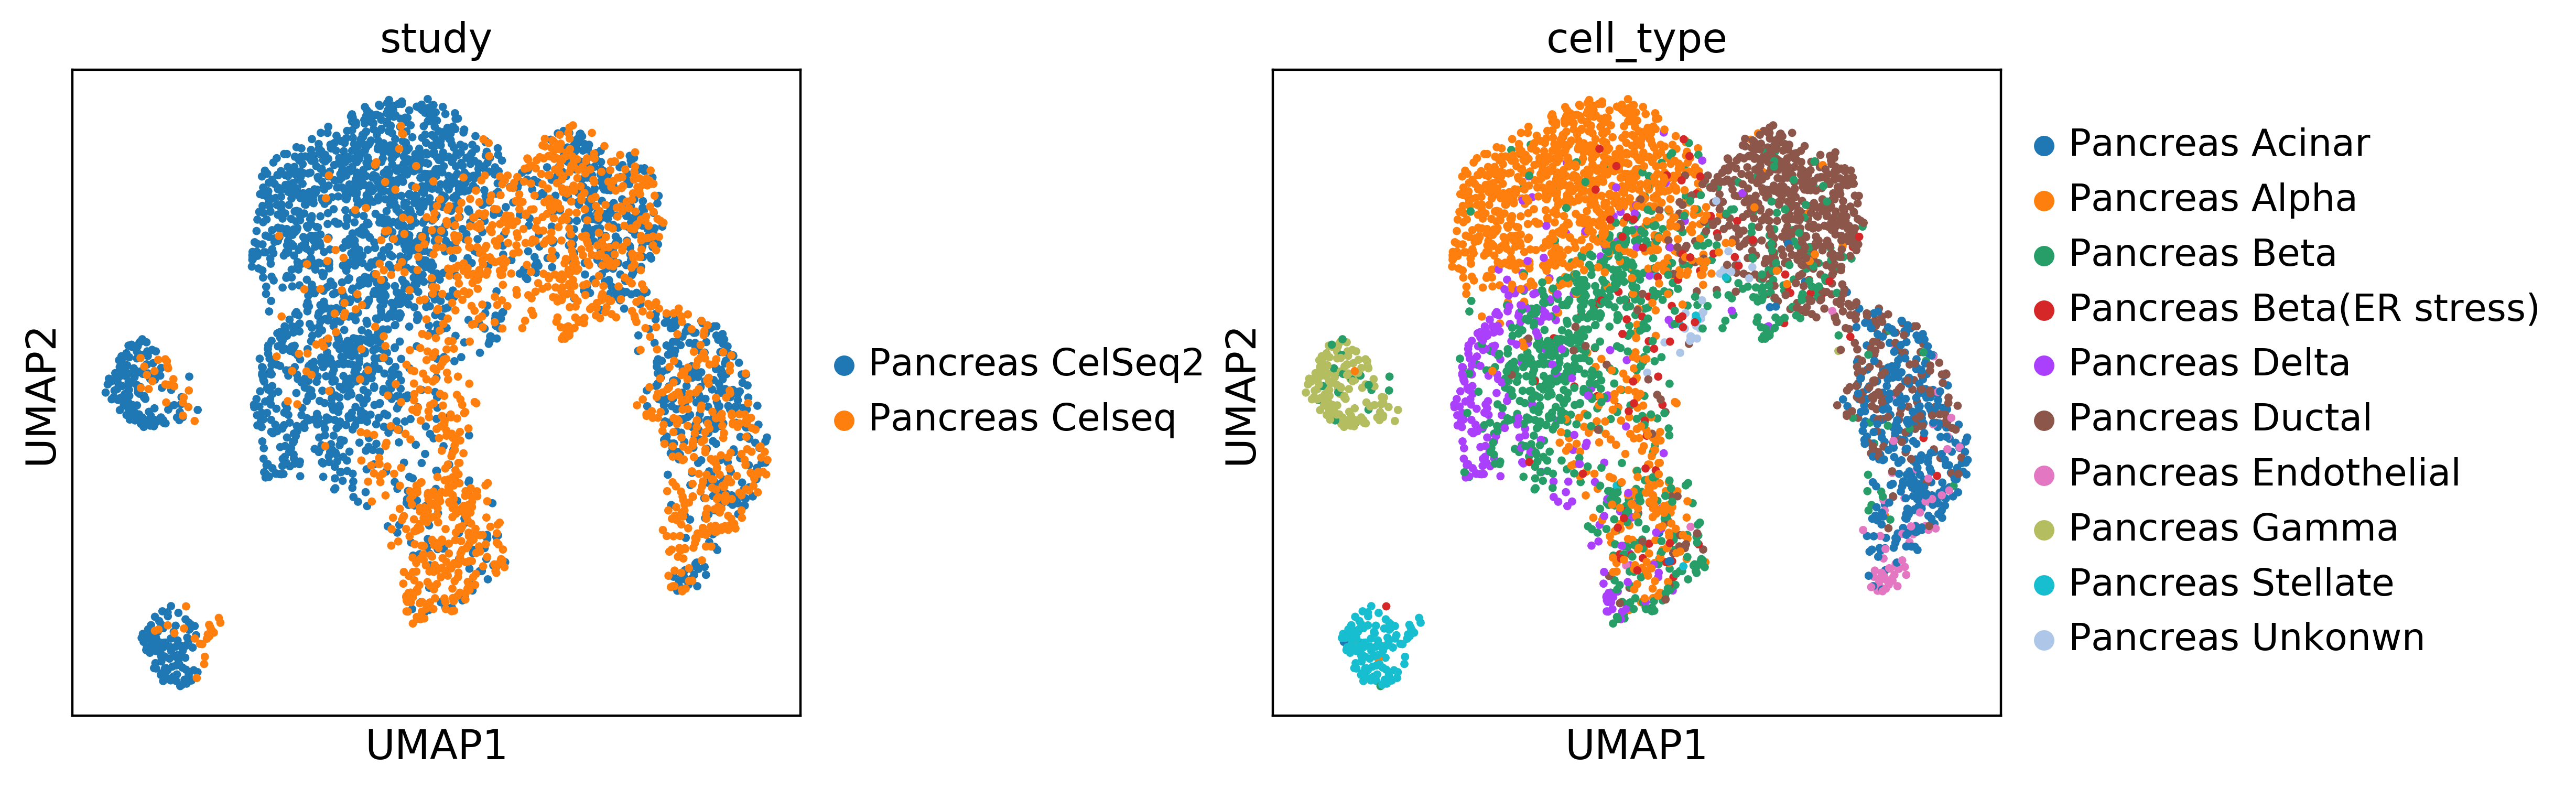

In [28]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [29]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.34188396479376054

In [37]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6032866712393262